#  通用题目

## 1.1 环境配置

2022-07-26 18:23:11.981087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 18:23:11.981104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-26 18:23:13.460975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-26 18:23:13.460992: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 18:23:13.461002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (imasonliu-LC4): /proc/driver/nvidia/version does not exist
2022-07-26 18:23:13.461158: I tensorflow/core/platform/cpu_feat

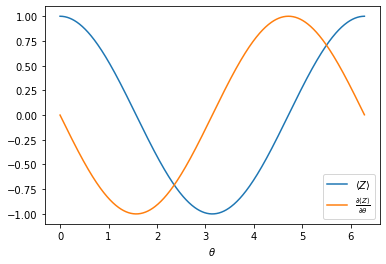

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorcircuit as tc

K = tc.set_backend("tensorflow")


@K.jit
def exp_z(param):
    c = tc.Circuit(1)
    c.rx(0, theta=param)
    return K.real(c.expectation_ps(z=[0]))


grad_z = K.grad(exp_z)

params = K.convert_to_tensor(np.arange(0, 2 * np.pi, 0.01))

plt.plot(params, [exp_z(param) for param in params], label=r"$\langle Z\rangle$")
plt.plot(
    params,
    [grad_z(param) for param in params],
    label=r"$\frac{\partial \langle Z\rangle}{\partial \theta}$",
)
plt.legend()
plt.xlabel(r"$\theta$")
plt.show()

## 1.2向量和矩阵

### 1.2.1矩阵旋转

In [3]:
import math
import numpy as np 

theta = 1
A = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])

B = np.array([1, 0])

np.matmul(A, B)

array([ 0.54030231, -0.84147098])

### 1.2.2矩阵指数

In [14]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np

K = tc.set_backend("tensorflow")

X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix
I = np.array([[1, 0],[0,1]])

P = X*1j
a = K.expm(P)
print(a)

theta = 1
b = K.expm(P*theta)
c = I*math.cos(theta) + P*math.sin(theta)
d = b-c
print(d)

tf.Tensor(
[[0.54030231+0.j         0.        +0.84147098j]
 [0.        +0.84147098j 0.54030231+0.j        ]], shape=(2, 2), dtype=complex128)
tf.Tensor(
[[ 0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -1.11022302e-16+0.j]], shape=(2, 2), dtype=complex128)


### 1.2.3矩阵关于向量的期望

/home/tencent_go/anaconda3/envs/tc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


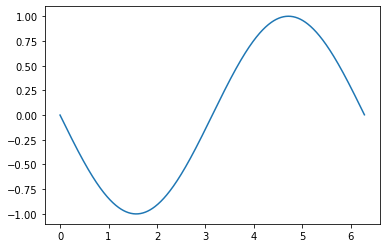

In [14]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

K = tc.set_backend("tensorflow")

X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix
P = X*1j
Q = Y

def func(theta):
    v_0 = np.array([[1, 0]])
    v = v_0 @ K.expm((P*theta)/2)
    A = K.transpose(K.conj(v))
    E = v @ Q @ A
    return E[0,0]

theta_list = np.arange(0, 2 * np.pi, 0.01)
plt.plot(theta_list, [func(theta) for theta in theta_list])
plt.show()

### 1.2.4张量积

In [24]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

n = 3
X = tc.gates._x_matrix 
Z = tc.gates._z_matrix
H = np.zeros((2**n,2**n))
for i in range(n):
    H +=np.kron(np.kron(np.identity(2**i),Z),np.identity(2**(n-i-1)))
for i in range(n-1):
    H +=np.kron(np.kron(np.identity(2**i),X),np.identity(2**(n-i-1)))*np.kron(np.kron(np.identity(2**(i+1)),X),np.identity(2**(n-i-2)))

print(H)
print(H[0,0])

[[ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -3.]]
3.0


### 1.2.5狄拉克符号

In [6]:
import math
import numpy as np

a = np.array([[0,
               0,
              1,
              0,
              0,
              0,
              0,
              0]])
b = np.array([[0,
               0,
              0,
              0,
              0,
              1,
              0,
              0]])
c = (a-b)/math.sqrt(2)
print(c)

[[ 0.          0.          0.70710678  0.          0.         -0.70710678
   0.          0.        ]]


## 1.3导数与梯度下降

### 1.3.1数值微分

In [5]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return x**2

y=0.00001
for x in range(5):
    a = (f(x+y)-f(x))/y
    print(a)

1e-05
2.00001000001393
4.000010000027032
6.000009999951316
8.00000999952033


### 1.3.2三角函数数值微分

不妨令$C=0:$
$$f'(x)=\frac {f(x+\delta )-f(x- \delta )}{\tau}$$


### 1.3.3单比特参数平移